# Sine wave forecasting using RNN

* Steps :
* First level of model tuning:
    1. Train, Test data split for first model
    2. Time series generation for a given data - in this case sine wave
    3. Early stopping callback for estimating number of epochs needed
    4. RNN/GRU/LSTM based sequence model 
    5. Forecast test data set and evaluate the model
    6. Till you get acceptable performance keep tryping different models/parameters
* Second level of model tuning:
    7. Once the model performing well on forecasted test data, create second model and do traing on entire data set. 
       As there will not be any validation data for early stopping, previous model epoch number can be used. 
    8. Forecast new data till the required time duration
    9. There will not be any validation data for forecasted output. But in this case as we are using sine wave as input we can
       validate the output.

## Sine wave data generation for input

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Note : The x-axis indexing is in radins 

In [207]:
# one full sine => 2*22/7 radians. Taking around 9-10 cycles = > 60 radians, and taking 10 samples for each cycle
# Min x limit = 0, max x limit = 60, x resolution => 6/10 or 60 steps

In [208]:
x_axis = np.linspace(0, 60, 601)
x_axis.shape

(601,)

In [209]:
#x_axis

In [210]:
sine = np.sin(x_axis)

In [211]:
sine.shape

(601,)

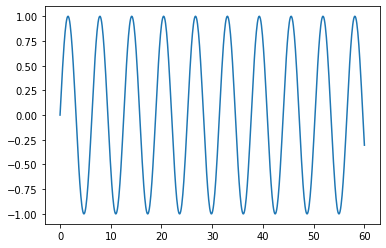

In [212]:
plt.plot(x_axis, sine)

#### Converting data in to data frame with time axis and values

In [213]:
sine_df = pd.DataFrame(sine, index = x_axis, columns = ['sine'])
sine_df

,sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
59.6,0.090138
59.7,-0.009739
59.8,-0.109519
59.9,-0.208205


## Train Test split for initial model training

#### Taking some portion of trailing data as test data

In [214]:
# there are 9 cycles in the given sine wave, taking 20% of data as test data (1-2 cycles)

In [215]:
total_data = sine_df
total_data_len = len(total_data)

In [216]:
total_data_len

601

In [217]:
#Some times the percentage split can be a fraction
test_start_index = total_data_len - int(np.round(total_data_len*0.2))
test_start_index

481

In [218]:
train_data = total_data.iloc[: test_start_index]
test_data = total_data.iloc[test_start_index:]

In [219]:
len(train_data) , len(test_data)

(481, 120)

In [220]:
train_data

,sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
47.6,-0.458325
47.7,-0.544766
47.8,-0.625764
47.9,-0.700509


In [221]:
test_data

,sine
48.1,-0.828324
48.2,-0.880118
48.3,-0.923117
48.4,-0.956893
48.5,-0.981108
...,...
59.6,0.090138
59.7,-0.009739
59.8,-0.109519
59.9,-0.208205


## Data scaling

In [222]:
from sklearn.preprocessing import MinMaxScaler

In [223]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

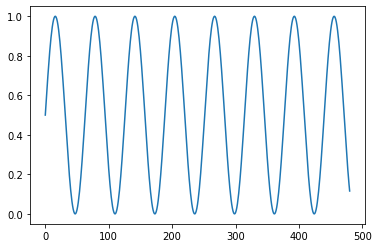

In [224]:
plt.plot(scaled_train_data)

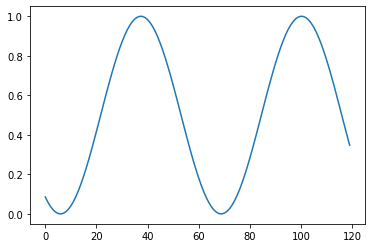

In [225]:
plt.plot(scaled_test_data)

## Time series generation for sequence model

In [226]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 

#### Length of output sequence:
   * It is the number of temporal data to consider at any point of time.
   * It should be atleast large enough to observable pattern in the input data sequence
   * In this sine wave example as there are nearly 60 samples per cycle, taking 80 samples as sequence length
   
#### batch size 
   * Number of time series samples in each batch
   * Number of seqences to generate for a batch

In [227]:
#time series generator for training data set
# sequqnce length at any point of time. It should 
length = 80 # Length of the output sequences (in number of timesteps) # it should capture any known pattern
batch_size = 1 # Number of timeseries samples in each batch

In [228]:
train_gen = TimeseriesGenerator(data = scaled_train_data, targets = scaled_train_data, length = length, batch_size = batch_size)

In [229]:
len(train_gen)

401

In [230]:
x, y = train_gen[0] 
x , y

(array([[[4.99999116e-01],
         [5.49916225e-01],
         [5.99334579e-01],
         [6.47760405e-01],
         [6.94709850e-01],
         [7.39713809e-01],
         [7.82322618e-01],
         [8.22110545e-01],
         [8.58680040e-01],
         [8.91665714e-01],
         [9.20737985e-01],
         [9.45606372e-01],
         [9.66022399e-01],
         [9.81782075e-01],
         [9.92727935e-01],
         [9.98750612e-01],
         [9.99789928e-01],
         [9.95835500e-01],
         [9.86926839e-01],
         [9.73152957e-01],
         [9.54651478e-01],
         [9.31607263e-01],
         [9.04250562e-01],
         [8.72854714e-01],
         [8.37733417e-01],
         [7.99237589e-01],
         [7.57751870e-01],
         [7.13690771e-01],
         [6.67494535e-01],
         [6.19624741e-01],
         [5.70559686e-01],
         [5.20789614e-01],
         [4.70811810e-01],
         [4.21125636e-01],
         [3.72227539e-01],
         [3.24606094e-01],
         [2.78737119e-01],
 

In [231]:
x.shape

(1, 80, 1)

In [232]:
y.shape

(1, 1)

In [233]:
test_gen = TimeseriesGenerator(data = scaled_test_data, targets = scaled_test_data, length = length, batch_size = batch_size)

In [234]:
len(test_gen)

40

## Early stopping call back
* As validation set contains less number of data, there can be noise in validation loss while training the model
* It is better not to have too hight value of patience

In [235]:
from tensorflow.keras.callbacks import EarlyStopping
callback_earlystop = EarlyStopping(monitor = 'val_loss', patience = 2)

## Model exploration - Simple RNN
   * Sequence model with SimpleRNN/LSTM
   * Input data shape should be (batch_size, timesteps, data_dim)
   * 1st hidden layer - 100 SimpleRNN/LSTM units, tanh activation
   * o/p Layer - 1 unit, liner activation

In [236]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU

timesteps = length # sequence length
data_dim = 1 # number of features

# expected input data shape: (batch_size, timesteps, data_dim) 0r (samples, time steps, features)
model = Sequential()

model.add(SimpleRNN(100, activation = 'tanh', input_shape=(timesteps, data_dim)))  # return a single vector of dimension 50
#model.add(GRU(100, activation = 'tanh', input_shape=(timesteps, data_dim)))  # return a single vector of dimension 50
#model.add(LSTM(100, activation = 'tanh', input_shape=(timesteps, data_dim)))  # return a single vector of dimension 50
model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 100)               10200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


## Model training

In [237]:
model.fit_generator(generator = train_gen, epochs = 20, callbacks = [callback_earlystop], validation_data = test_gen)

Epoch 1/20
401/401 [==============================] - 67s 168ms/step - loss: 0.0045 - val_loss: 8.2687e-04
Epoch 2/20
401/401 [==============================] - 69s 171ms/step - loss: 9.0703e-05 - val_loss: 1.3092e-04
Epoch 3/20
401/401 [==============================] - 69s 172ms/step - loss: 5.1688e-04 - val_loss: 2.2773e-04
Epoch 4/20
401/401 [==============================] - 67s 168ms/step - loss: 4.9309e-05 - val_loss: 1.7278e-06
Epoch 5/20
401/401 [==============================] - 68s 171ms/step - loss: 2.4027e-04 - val_loss: 9.2751e-06
Epoch 6/20
401/401 [==============================] - 69s 172ms/step - loss: 5.1499e-05 - val_loss: 3.3305e-05


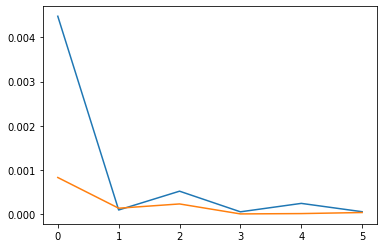

In [238]:
model_hist = pd.DataFrame(model.history.history)
plt.plot(model_hist[['loss', 'val_loss']])

#### Forecasting new data
* As we keep forecasting new data, keep appending last forecasted value in to the input sequence
* updation of time serioes sequence : remove value from head(0th index)and aapend forecasted value at the tail(last index)

In [239]:
# first time series sequence
input_sequence = scaled_train_data[-length:] 
#reshape sequence with batches info
input_sequence = input_sequence.reshape((1, length, data_dim))
pred = model.predict(input_sequence)[0]
pred

array([0.07939932], dtype=float32)

In [240]:
scaled_test_data[0]

array([0.0858336])

In [241]:
input_sequence.shape

(1, 80, 1)

In [242]:
input_sequence

array([[[8.37405820e-01],
        [7.98881698e-01],
        [7.57371240e-01],
        [7.13289205e-01],
        [6.67076045e-01],
        [6.19193508e-01],
        [5.70120021e-01],
        [5.20345908e-01],
        [4.70368497e-01],
        [4.20687145e-01],
        [3.71798252e-01],
        [3.24190300e-01],
        [2.78338972e-01],
        [2.34702398e-01],
        [1.93716581e-01],
        [1.55791039e-01],
        [1.21304709e-01],
        [9.06021693e-02],
        [6.39901882e-02],
        [4.17346643e-02],
        [2.40579672e-02],
        [1.11367167e-02],
        [3.10001778e-03],
        [2.81703720e-05],
        [1.95186738e-03],
        [8.85188786e-03],
        [2.06592891e-02],
        [3.72560954e-02],
        [5.84764771e-02],
        [8.41084070e-02],
        [1.13895779e-01],
        [1.47540969e-01],
        [1.84707803e-01],
        [2.25024924e-01],
        [2.68089497e-01],
        [3.13471233e-01],
        [3.60716695e-01],
        [4.09353821e-01],
        [4.5

In [243]:
# After updating with forecased value
input_sequence = np.append(input_sequence[:,1:,:], [[pred]], axis = 1)

In [244]:
input_sequence

array([[[7.98881698e-01],
        [7.57371240e-01],
        [7.13289205e-01],
        [6.67076045e-01],
        [6.19193508e-01],
        [5.70120021e-01],
        [5.20345908e-01],
        [4.70368497e-01],
        [4.20687145e-01],
        [3.71798252e-01],
        [3.24190300e-01],
        [2.78338972e-01],
        [2.34702398e-01],
        [1.93716581e-01],
        [1.55791039e-01],
        [1.21304709e-01],
        [9.06021693e-02],
        [6.39901882e-02],
        [4.17346643e-02],
        [2.40579672e-02],
        [1.11367167e-02],
        [3.10001778e-03],
        [2.81703720e-05],
        [1.95186738e-03],
        [8.85188786e-03],
        [2.06592891e-02],
        [3.72560954e-02],
        [5.84764771e-02],
        [8.41084070e-02],
        [1.13895779e-01],
        [1.47540969e-01],
        [1.84707803e-01],
        [2.25024924e-01],
        [2.68089497e-01],
        [3.13471233e-01],
        [3.60716695e-01],
        [4.09353821e-01],
        [4.58896644e-01],
        [5.0

In [255]:
# first time series sequence
input_sequence = scaled_train_data[-length:] 
#reshape sequence with batches info
input_sequence = input_sequence.reshape((1, length, data_dim))

forecast = []
#keep updataing input_sequence with newly forecasted value till the required number of samples
for i in range(len(test_data)):
    pred = model.predict(input_sequence)[0]
    forecast.append(pred)
    #update input sequence - sequence shape (1, length, 1), prediction value shape (1,1)
    input_sequence = np.append(input_sequence[:,1:,:], [[pred]], axis = 1)
    

#### Rescale the forecast data to validate with test data

In [256]:
forecast_unscaled = forecast

In [257]:
forecast = scaler.inverse_transform(forecast)

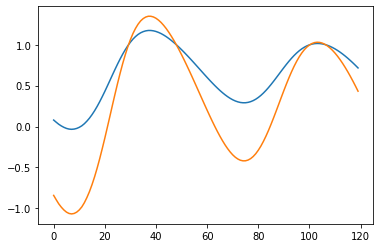

In [261]:
plt.plot(forecast_unscaled)
plt.plot(forecast)

In [262]:
test_data['SimpleRNN_forecast'] = forecast

c:\users\rajasm\appdata\local\continuum\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [263]:
test_data

,sine,SimpleRNN_forecast
48.1,-0.828324,-0.841193
48.2,-0.880118,-0.894607
48.3,-0.923117,-0.944911
48.4,-0.956893,-0.985521
48.5,-0.981108,-1.019305
...,...,...
59.6,0.090138,0.668646
59.7,-0.009739,0.613177
59.8,-0.109519,0.555132
59.9,-0.208205,0.494636


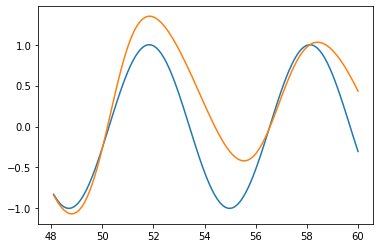

In [264]:
plt.plot(test_data)

In [265]:
test_data.min()

sine                 -0.999986
SimpleRNN_forecast   -1.067434
dtype: float64

In [266]:
test_data.max()

sine                  0.999811
SimpleRNN_forecast    1.347669
dtype: float64

## New model exploration - LSTM

In [267]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU

timesteps = length # sequence length
data_dim = 1 # number of features

# expected input data shape: (batch_size, timesteps, data_dim) 0r (samples, time steps, features)
model = Sequential()

#model.add(SimpleRNN(100, activation = 'tanh', input_shape=(timesteps, data_dim)))  # return a single vector of dimension 50
#model.add(GRU(100, activation = 'tanh', input_shape=(timesteps, data_dim)))  # return a single vector of dimension 50
model.add(LSTM(100, activation = 'tanh', input_shape=(timesteps, data_dim)))  # return a single vector of dimension 50
model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [268]:
model.fit_generator(generator = train_gen, epochs = 20, callbacks = [callback_earlystop], validation_data = test_gen)

Epoch 1/20
401/401 [==============================] - 144s 360ms/step - loss: 0.0126 - val_loss: 4.4459e-05
Epoch 2/20
401/401 [==============================] - 141s 352ms/step - loss: 3.1092e-04 - val_loss: 1.8712e-04
Epoch 3/20
401/401 [==============================] - 131s 326ms/step - loss: 1.0576e-04 - val_loss: 9.7053e-04


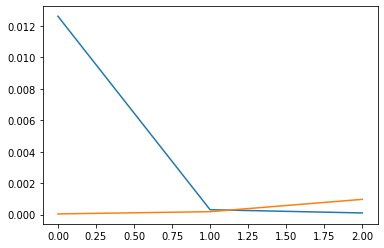

In [269]:
model_hist = pd.DataFrame(model.history.history)
plt.plot(model_hist[['loss', 'val_loss']])

#### Model evaluation

In [270]:
#Forecasting with the new model
# first time series sequence
input_sequence = scaled_train_data[-length:] 
#reshape sequence with batches info
input_sequence = input_sequence.reshape((1, length, data_dim))

forecast = []
#keep updataing input_sequence with newly forecasted value till the required number of samples
for i in range(len(test_data)):
    pred = model.predict(input_sequence)[0]
    forecast.append(pred)
    #update input sequence - sequence shape (1, length, 1), prediction value shape (1,1)
    input_sequence = np.append(input_sequence[:,1:,:], [[pred]], axis = 1)
    

#### Re-scale the output  

In [271]:
forecast = scaler.inverse_transform(forecast)

In [272]:
test_data['LSTM_forecast'] = forecast

c:\users\rajasm\appdata\local\continuum\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [273]:
test_data

,sine,SimpleRNN_forecast,LSTM_forecast
48.1,-0.828324,-0.841193,-0.802049
48.2,-0.880118,-0.894607,-0.854770
48.3,-0.923117,-0.944911,-0.896218
48.4,-0.956893,-0.985521,-0.926667
48.5,-0.981108,-1.019305,-0.946320
...,...,...,...
59.6,0.090138,0.668646,0.957785
59.7,-0.009739,0.613177,0.905347
59.8,-0.109519,0.555132,0.847548
59.9,-0.208205,0.494636,0.784841


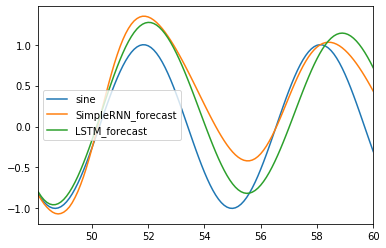

In [275]:
test_data.plot()

## Fore casting unknown values
* Train the model on entire data set. Do not need validation data so the earlystopping callback
* Use previous model epoach info for training iterations
* after the model is trained, we can forecast the new data

#### Data scaling

In [276]:
scaler = MinMaxScaler()
scaler.fit(total_data)
scaled_data = scaler.transform(total_data)

#### Timeseries generator

In [277]:
train_gen = TimeseriesGenerator(scaled_data, scaled_data, length = length, batch_size = batch_size)
len(train_gen)

521

#### Model creation

In [278]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', input_shape = (timesteps, data_dim)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


#### Model training - with the same number of old model epochs

In [279]:
model.fit_generator(train_gen, epochs = 2)

Epoch 1/2
521/521 [==============================] - 173s 333ms/step - loss: 0.0056 - accuracy: 0.0038
Epoch 2/2
521/521 [==============================] - 174s 333ms/step - loss: 1.6850e-04 - accuracy: 0.0038


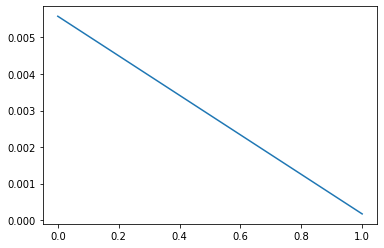

In [282]:
model_hist = pd.DataFrame(model.history.history)
plt.plot(model_hist['loss'])

#### Forecasting new data
* As we keep forecasting new data, keep appending last forecasted value in to the input sequence

In [283]:
#Forecasting with the new model
# first time series sequence
input_sequence = scaled_data[-length:] 
#reshape sequence with batches info
input_sequence = input_sequence.reshape((1, length, data_dim))

forecast = []
#keep updataing input_sequence with newly forecasted value till the required number of samples
for i in range(len(test_data)):
    pred = model.predict(input_sequence)[0]
    forecast.append(pred)
    #update input sequence - sequence shape (1, length, 1), prediction value shape (1,1)
    input_sequence = np.append(input_sequence[:,1:,:], [[pred]], axis = 1)
    

In [284]:
forecast = scaler.inverse_transform(forecast)

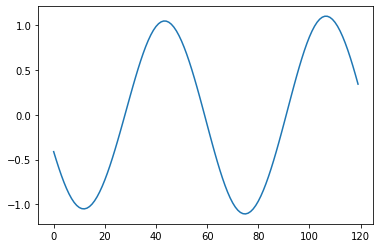

In [285]:
plt.plot(forecast)

#### Combine the forecasted data with the input (training) data 

In [352]:
forecast_x = np.linspace(60.1, 72, num = 120) 

In [353]:
forecast_x.shape

(120,)

In [364]:
forecast_x

array([60.1, 60.2, 60.3, 60.4, 60.5, 60.6, 60.7, 60.8, 60.9, 61. , 61.1,
       61.2, 61.3, 61.4, 61.5, 61.6, 61.7, 61.8, 61.9, 62. , 62.1, 62.2,
       62.3, 62.4, 62.5, 62.6, 62.7, 62.8, 62.9, 63. , 63.1, 63.2, 63.3,
       63.4, 63.5, 63.6, 63.7, 63.8, 63.9, 64. , 64.1, 64.2, 64.3, 64.4,
       64.5, 64.6, 64.7, 64.8, 64.9, 65. , 65.1, 65.2, 65.3, 65.4, 65.5,
       65.6, 65.7, 65.8, 65.9, 66. , 66.1, 66.2, 66.3, 66.4, 66.5, 66.6,
       66.7, 66.8, 66.9, 67. , 67.1, 67.2, 67.3, 67.4, 67.5, 67.6, 67.7,
       67.8, 67.9, 68. , 68.1, 68.2, 68.3, 68.4, 68.5, 68.6, 68.7, 68.8,
       68.9, 69. , 69.1, 69.2, 69.3, 69.4, 69.5, 69.6, 69.7, 69.8, 69.9,
       70. , 70.1, 70.2, 70.3, 70.4, 70.5, 70.6, 70.7, 70.8, 70.9, 71. ,
       71.1, 71.2, 71.3, 71.4, 71.5, 71.6, 71.7, 71.8, 71.9, 72. ])

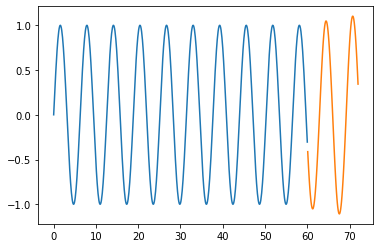

In [366]:
plt.plot(total_data.index, total_data)
plt.plot(forecast_x, forecast)

## Good bye !!